In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, find_stats

In [2]:
LOCATIONS = 4                 #number of locations to be visited
VERBOSE = False               #controls how much is printed
TOLERANCE = 1e-1              #Tolerance
#RELEVANT_VALUES = 50         #controls how many of the items to average over as a percentage
                              #eg 100 = all 
                              #30 = top 30%
#LEARNING_RATE = 1e-2         #learning rate
#UPDATES = 100                #updates, or iterations
#PRINT_FREQUENCY = 20         #how often results are printed out
#SPSA = False                 #SPSA stochastic gradient descent used
#DEBUG = False                #Extra data printed out

From the number of locations visited find the qubits and longest binary string.

In [3]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 3 qubits needed.  The longest binary string is 2


Data sources are held locally to avoid downstream dependencies.

In [4]:
data_sources = {  4 : {'file' : 'data/four_d.txt', 'best' : 21},
                  5 : {'file' : 'data/five_d.txt', 'best' : 19},
                 11 : {'file' : 'data/dg11_d.txt', 'best' : 253},
                 15 : {'file' : 'data/p01_d.txt',  'best' : 291},
                 17 : {'file' : 'data/gr17_d.txt', 'best' : 2085},
                 26 : {'file' : 'data/fri26_d.txt', 'best' : 699},
                 42 : {'file' : 'data/dantzig42_d.txt', 'best' : 33_523},
                }

In [5]:
filename = read_file_name(LOCATIONS, data_sources)
best = data_sources[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best}.')

Data will be read from filename data/four_d.txt.  It is known that the shortest distance is 21.


In [6]:
# may not be needed.
#from qiskit_algorithms.optimizers import COBYLA

Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

In [8]:
def initialise_parameters(qubits):
    #initialise parameter text
    init_params = []
    for i in range(qubits):
        text1 = "weight" + str(2*i)
        text2 = "weight" + str(2*i +1 )
        init_params.append(Parameter(text1 ))
        init_params.append(Parameter(text2 ))
    #initialise parameters with random weights    
    for i in range(qubits * 2):
        init_params[i] = random.random() * 2 * math.pi
        if VERBOSE:
            print(init_params[i])
    return init_params

In [9]:
def vqc_circuit(qubits, params):
    #set up a variational quantum circuit
    qc = QuantumCircuit(qubits)
    for i in range(qubits):
        qc.h(i)
        qc.ry(params[2*i], i)
        qc.rx(params[2*i+1], i)
    for i in range(qubits-1):
            qc.cx(i,i+1)
    qc.measure_all()
    return qc

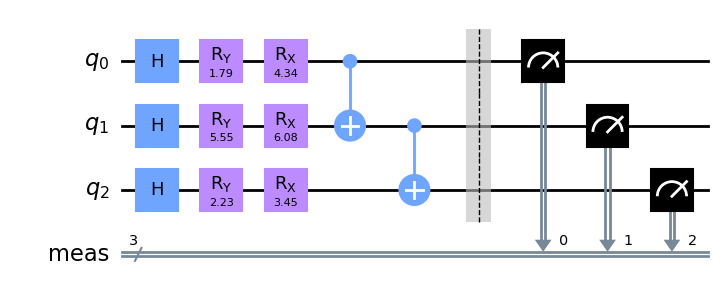

In [10]:
from qiskit_aer.primitives import SamplerV2

sampler = SamplerV2()
SHOTS = 1024

init_params = initialise_parameters(qubits)

#calculate and draw first circuit
qc = vqc_circuit(qubits, init_params)

#draw the first circuit
qc.draw("mpl", style="clifford")

In [11]:
def cost_func_evaluate(params):
    qc2 = vqc_circuit(qubits, params)
    job = sampler.run([qc2])
    results = job.result()
    counts = results[0].data.meas.get_counts()
    if VERBOSE:
        print(counts)
    cost, lowest = find_stats(counts, LOCATIONS, distance_array, SHOTS)
    print(f'{cost=}, {lowest=}')
    #graph_list.append([cost, lowest])
    return(cost)

In [14]:
param_vals = init_params
#gradient = ParamShiftSamplerGradient(sampler)

qc_sample = vqc_circuit(qubits, param_vals)
#pss_grad_result = gradient.run(qc_sample, [param_vals]).result().gradients
#print("State sampler gradient computed with parameter shift", pss_grad_result)

In [15]:
param_vals

[1.7919248490360933,
 4.342132481109082,
 5.553231934876725,
 6.0841133644067655,
 2.2313170363617005,
 3.449769115468229]